# ROF Denoising

$$\textrm{minimize} \quad \|u - g\|_{2}^{2} + \lambda\||Du|_2\|_1 $$

## First order primal dual algorithm 

Primal dual formulation of the primal problem

$$\min_{u \in X} \max_{p \in Y}\quad - \langle u, D^*p\rangle + \frac{\lambda}{2}\|u-g\|_2^2 - \iota_{P}(p)$$

Using Alg. 1 from 
Chambolle and Pock replacing the resolvent by the proximal operator yields the following algorithm with convergence $\mathcal{O}(1/N)$

$$
   \begin{aligned}
      p^{n+1} &:= \textrm{prox}_{\sigma f_1}(p^n + \sigma D^* \bar{u}^n), \quad f_1(\cdot) = \iota_P(\cdot) \\
      u^{n+1} &:= g + \textrm{prox}_{\tau f_2}(u^n - \tau Dp^{n+1} - g), \quad f_2(\cdot) = \frac{\lambda}{2}\|\cdot\|_2^2 \\
      \bar{u}^{n+1} &:= u^{n+1} + \theta(u^{n+1} - u^n)
   \end{aligned}
$$

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import vip

import sys
sys.path.append("..")
import ia2

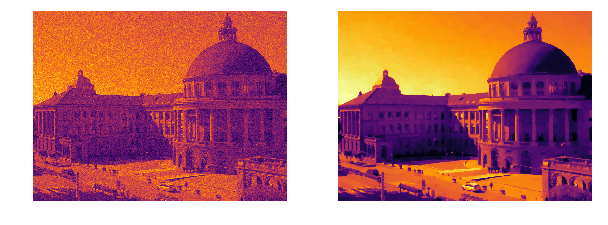

In [3]:
sigma = 0.1
rand = np.random.RandomState(2)

img = mpimg.imread("data/ETH-greyscale.png")
img_noise = img + sigma*rand.randn(*img.shape)

gth = np.load("data/primal-dual-ground-thruth-sigma-1.0-tau-0.1-theta-1.0-rho-10.0.npy")

fig, axes = plt.subplots(1, 2, figsize= (10,5))
axes[0].imshow(img_noise, cmap="inferno")
axes[1].imshow(gth, cmap="inferno")
for ax in axes:
    ax.axis("off")

### Euclidean projection on L2 balls 

$$ p^{n+1} := \textrm{prox}_{\sigma f_1}(p^n + \sigma D^* \bar{u}^n), \quad f_1(\cdot) = \iota_P(\cdot) $$

using the proximal notations results in

$$p_{i,j} = \frac{\tilde{p}_{i,j}}{\max(1, \|\tilde{p}_{i,j}\|)}, \quad \tilde{p} = p^n + \sigma D^* \bar{u}^n$$

In [4]:
def build_step_max_proj(sigma, g):
    D = vip.ForwardFiniteDifferences(g.shape)
    
    def max_proj_step(x_bar, y):
        p = y + sigma*D(x_bar)
        
        p[np.abs(p) > 1] = np.sign(p[np.abs(p) > 1])
        return p
    
    return max_proj_step

### Data term

$$ u^{n+1} := g + \textrm{prox}_{\tau f_2}(u^n - \tau Dp^{n+1} - g), \quad f_2(\cdot) = \frac{\lambda}{2}\|\cdot\|_2^2 $$




In [5]:
def build_step_l2(tau, rho, g):
    D = vip.ForwardFiniteDifferences(g.shape)
    
    def l2_step(x, y):
        return g + vip.prox_sum_of_squares(x - tau*D.T(y) - g, tau*rho)
    
    return l2_step

In [6]:
def build_step_update(theta):
    def update_step(x, x_old):
        return x + theta*(x - x_old)
    return update_step

In [7]:
def build_step_energy(gth, rho):
    D = vip.ForwardFiniteDifferences(gth.shape)
    
    def energy_step(x):
        return np.sum(np.square(gth - x)) + 2/(rho)*np.sum(np.linalg.norm(D(x), axis=0))
    
    return energy_step

In [8]:
img2 = ia2.Placeholder("img2")
gth2 = ia2.Placeholder("gth")

y = ia2.Variable("y", lambda x: vip.ForwardFiniteDifferences(x.shape)(x), x=img2)
x = ia2.Variable("x", lambda x: (x, [np.zeros_like(x)]), x=img2)
x_bar = ia2.Variable("x_bar", lambda x: np.zeros_like(x), x=img2)
energy = ia2.Variable("energy", lambda: 0.0, keep_history=True)

sigma = ia2.Parameter("sigma", 1.)
tau = ia2.Parameter("tau", 1.)
theta = ia2.Parameter("theta", 1.0)
rho = ia2.Parameter("rho", 10.0)

In [9]:
with ia2.DefaultAlgorithm(ia2.SequentialScheduler(), max_iter=100) as (k, alg):
    y[k+1] = alg.new_step("max_proj", build_step_max_proj, sigma=sigma, g=img2, x_bar=x_bar[k], y=y[k])
    x[k+1] = alg.new_step("l2", build_step_l2, tau=tau, rho=rho, g=img2, x=x[k], y=y[k+1])
    x_bar[k+1] = alg.new_step("update", build_step_update, theta=theta, x=x[k+1], x_old=x[k])
    energy[k+1] = alg.new_step("energy", build_step_energy, x=x[k+1], gth=gth2, rho=rho)

In [10]:
alg.dependency_graph

Node(name='max_proj')          -> 	Node(name='l2')
Node(name='max_iter_stop')
Node(name='l2')                -> 	Node(name='energy')
Node(name='l2')                -> 	Node(name='update')

In [11]:
alg.scheduler.scheduling_order

['max_proj', 'l2', 'energy', 'update', 'max_iter_stop']

In [12]:
it2 = ia2.IterationContext(alg)

In [13]:
it2.run(img2=img_noise, gth=gth, max_iter=200)

In [14]:
out = it2.cache['x'][0]

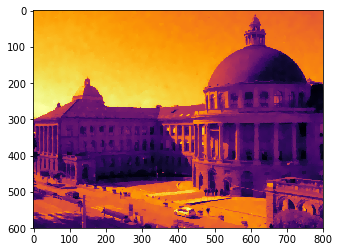

In [15]:
plt.imshow(out, cmap="inferno")

In [16]:
energy = it2.cache['energy'].data

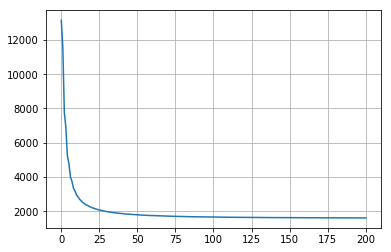

In [17]:
plt.plot(energy[1:])
plt.grid()